# **The fourth in-class-exercise (40 points in total, 03/29/2022)**

Question description: Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks:

## (1) (10 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=f613b8cc07fe124d50eb3e897e69de935f4a13e4907b55d75f6f24a5876544b9
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
df = pd.read_csv("data.csv")

#Cleaning the data
import re

def cleantext(tweets):
    text = re.sub(r'@[A-Za-z0-9_]+', '', tweets) #removes @mentions
    text = re.sub(r'#[A-Za-z0-9_]+', '', text) #removing Hashtag symbols.
    text = re.sub(r'RT[\s]+', '', text) #removing Retweet symbol (RT).
    text = re.sub(r'https?:\/\/\S+', '', text) #remove URL's.
    text = re.sub(r"www.\S+", "", text)
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]',' ', text)
    text = re.sub("[^A-Za-z0-9]"," ", text)#Filtering non-alphanumeric characters
    text = re.sub('\\n', '', text)#removing the '\n' character
    text = re.sub(r'[0-9]+', '', text)#removing numbers
    
    return text

df["Text"] = df["Text"].apply(cleantext)

# Convert to list
data = df.Text.values.tolist()

In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [12]:
b = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
t = gensim.models.Phrases(b[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bmod = gensim.models.phrases.Phraser(b)
tmod = gensim.models.phrases.Phraser(t)

# See trigram example
print(tmod[bmod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['optimistic', 'about', 'our', 'ability', 'to', 'prevent', 'the', 'next', 'pandemic', 'we', 'have', 'learned', 'so', 'much', 'from', 'covid', 'and', 'the', 'innovations', 'have', 'been', 'tremendous']


In [15]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bmod[doc] for doc in texts]

def make_trigrams(texts):
    return [tmod[bmod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [16]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['optimistic', 'ability', 'prevent', 'next', 'pandemic', 'learn', 'much', 'covid', 'innovation', 'tremendous']]


In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [18]:
id2word[0]

'ability'

In [19]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ability', 1),
  ('covid', 1),
  ('innovation', 1),
  ('learn', 1),
  ('much', 1),
  ('next', 1),
  ('optimistic', 1),
  ('pandemic', 1),
  ('prevent', 1),
  ('tremendous', 1)]]

In [20]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [21]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.053*"make" + 0.038*"world" + 0.026*"need" + 0.023*"progress" + '
  '0.021*"work" + 0.021*"way" + 0.019*"young" + 0.018*"investment" + '
  '0.018*"well" + 0.017*"important"'),
 (1,
  '0.048*"great" + 0.036*"help" + 0.028*"technology" + 0.025*"take" + '
  '0.020*"invest" + 0.020*"family" + 0.019*"create" + 0.019*"problem" + '
  '0.016*"support" + 0.016*"action"'),
 (2,
  '0.036*"energy" + 0.036*"talk" + 0.029*"new" + 0.023*"emission" + '
  '0.022*"climate_change" + 0.021*"ask" + 0.021*"challenge" + 0.020*"excited" '
  '+ 0.017*"avoid" + 0.017*"get"'),
 (3,
  '0.042*"thank" + 0.032*"inspire" + 0.029*"disease" + 0.029*"leader" + '
  '0.026*"help" + 0.024*"share" + 0.023*"live" + 0.023*"save" + 0.022*"fight" '
  '+ 0.021*"world"'),
 (4,
  '0.036*"today" + 0.029*"story" + 0.027*"country" + 0.022*"learn" + '
  '0.020*"love" + 0.019*"woman" + 0.018*"get" + 0.018*"child" + 0.018*"worker" '
  '+ 0.017*"bring"'),
 (5,
  '0.059*"could" + 0.026*"life" + 0.019*"remarkable" + 0.018*"case" +

In [22]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.423869100267821

Coherence Score:  0.37210532947820885


In [23]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.285975 -0.040638       1        1  18.180312
9     -0.088794  0.087855       2        1  11.778260
3     -0.099968 -0.124893       3        1  11.201450
7     -0.034232  0.263263       4        1  10.912257
1      0.046487 -0.140963       5        1   9.415156
8      0.060030 -0.158706       6        1   9.252775
4      0.085261  0.075989       7        1   9.133447
2      0.219148  0.003581       8        1   9.077325
6      0.050755 -0.031541       9        1   5.941911
5      0.047286  0.066052      10        1   5.107107, topic_info=       Term        Freq       Total Category  logprob  loglift
18   health   80.000000   80.000000  Default  30.0000  30.0000
95     make  127.000000  127.000000  Default  29.0000  29.0000
17     good   63.000000   63.000000  Default  28.0000  28.0000
32   people  106.000000  106.000000  Default  27.0000  27.0000
396    book   63.000000   63.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
29     life   15.697854   65.032019  Topic10  -3.6573   1.5532
295   would   10.961280   35.076555  Topic10  -4.0165   1.8114
256     see    8.886415   62.133763  Topic10  -4.2263   1.0298
41     work    8.627387  118.632707  Topic10  -4.2559   0.3534
635  always    4.644177   15.553510  Topic10  -4.8752   1.7659

[441 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
352       2  0.876706   access
116       5  0.935453   action
998       6  0.807545  address
998      10  0.100943  address
325       3  0.914217  advance
...     ...       ...      ...
23        3  0.160353     year
23        4  0.531698     year
23        5  0.008440     year
2041      5  0.933699    yield
168       1  0.989574    young

[506 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 10, 4, 8, 2, 9, 5, 3, 7, 6])

In [24]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

mallet_path = "/content/mallet-2.0.8/bin/mallet"
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

--2022-04-25 03:45:53--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-04-25 03:45:53--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  9.96MB/s    in 1.6s    

2022-04-25 03:45:55 (9.96 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

In [25]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(7,
  [('learn', 0.1026694045174538),
   ('talk', 0.07802874743326489),
   ('favorite', 0.049281314168377825),
   ('meet', 0.043121149897330596),
   ('back', 0.04106776180698152),
   ('excite', 0.03490759753593429),
   ('plan', 0.030800821355236138),
   ('recently', 0.030800821355236138),
   ('amazing', 0.026694045174537988),
   ('education', 0.026694045174537988)]),
 (2,
  [('inspire', 0.09274193548387097),
   ('share', 0.06854838709677419),
   ('story', 0.06653225806451613),
   ('poverty', 0.04838709677419355),
   ('start', 0.04233870967741935),
   ('woman', 0.036290322580645164),
   ('late', 0.034274193548387094),
   ('team', 0.028225806451612902),
   ('wait', 0.02620967741935484),
   ('kid', 0.024193548387096774)]),
 (3,
  [('people', 0.11727078891257996),
   ('day', 0.07462686567164178),
   ('climate_change', 0.057569296375266525),
   ('change', 0.0511727078891258),
   ('power', 0.03837953091684435),
   ('face', 0.023454157782515993),
   ('black', 0.023454157782515993),
   ('answ

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [30]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=2)

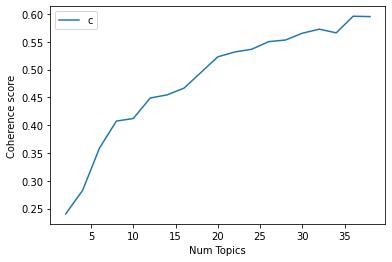

In [31]:
 # Show graph
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [32]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2403
Num Topics = 4  has Coherence Value of 0.2825
Num Topics = 6  has Coherence Value of 0.3588
Num Topics = 8  has Coherence Value of 0.4074
Num Topics = 10  has Coherence Value of 0.412
Num Topics = 12  has Coherence Value of 0.4489
Num Topics = 14  has Coherence Value of 0.4545
Num Topics = 16  has Coherence Value of 0.4667
Num Topics = 18  has Coherence Value of 0.4949
Num Topics = 20  has Coherence Value of 0.5231
Num Topics = 22  has Coherence Value of 0.5317
Num Topics = 24  has Coherence Value of 0.5366
Num Topics = 26  has Coherence Value of 0.5503
Num Topics = 28  has Coherence Value of 0.5533
Num Topics = 30  has Coherence Value of 0.5655
Num Topics = 32  has Coherence Value of 0.5728
Num Topics = 34  has Coherence Value of 0.5662
Num Topics = 36  has Coherence Value of 0.5961
Num Topics = 38  has Coherence Value of 0.5954


In [33]:
# Select the model and print the topics
optimal_model = model_list[14]
#model_list[4] indicates that: model_list is a list that has been defined earlier and contains the number of topics and its coherence values.
# Since I have decided 10 to be the ideal number of topics, Topics number 30 is present in the 14th place of the list.
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(14,
  '0.326*"world" + 0.070*"lead" + 0.053*"reduce" + 0.039*"call" + '
  '0.031*"effort" + 0.028*"hopeful" + 0.022*"drive" + 0.022*"benefit" + '
  '0.020*"glad" + 0.020*"powerful"'),
 (17,
  '0.097*"today" + 0.091*"critical" + 0.076*"action" + 0.073*"climate" + '
  '0.063*"continue" + 0.048*"congratulation" + 0.033*"encourage" + '
  '0.030*"speak" + 0.030*"invest" + 0.030*"impact"'),
 (24,
  '0.142*"important" + 0.085*"investment" + 0.082*"build" + 0.038*"support" + '
  '0.035*"development" + 0.028*"nuclear" + 0.025*"tech" + '
  '0.025*"infrastructure" + 0.022*"source" + 0.022*"insight"'),
 (21,
  '0.091*"step" + 0.074*"close" + 0.071*"move" + 0.051*"easy" + 0.051*"test" + '
  '0.047*"month" + 0.044*"diagnostic" + 0.037*"achieve" + 0.030*"difference" + '
  '0.030*"scale"'),
 (16,
  '0.060*"scientist" + 0.050*"access" + 0.047*"case" + 0.040*"put" + '
  '0.037*"day" + 0.037*"story" + 0.033*"eliminate" + 0.030*"toilet" + '
  '0.030*"fascinating" + 0.027*"explain"'),
 (15,
  '0.207*"cou

## (2) (10 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [ ]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [ ]:
# Write your code here
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts
preprocess_data(data)





[['foundat', 'statist', 'natur', 'languag', 'process'],
 ['maximum', 'entropi', 'approach', 'natur', 'languag', 'process'],
 ['natur', 'languag', 'process'],
 ['linguist', 'natur', 'languag', 'process'],
 ['natur', 'languag', 'process'],
 ['natur', 'languag', 'process', 'almost', 'scratch'],
 ['natur', 'languag', 'process'],
 ['natur', 'languag', 'process', 'robot'],
 ['tutori', 'natur', 'languag', 'process'],
 ['ambigu', 'natur', 'languag', 'process'],
 ['statist', 'natur', 'languag', 'process'],
 ['natur', 'languag', 'process', 'inform', 'retriev'],
 ['natur', 'languag', 'process'],
 ['natur', 'languag', 'process', 'lyric'],
 ['transform',
  'base',
  'error',
  'driven',
  'learn',
  'natur',
  'languag',
  'process',
  'case',
  'studi',
  'part',
  'speech',
  'tag'],
 ['connectionist', 'natur', 'languag', 'process'],
 ['chao', 'natur', 'languag', 'process'],
 ['natur', 'languag', 'process'],
 ['natur', 'languag', 'process', 'introduct'],
 ['overview', 'natur', 'languag', 'process

In [ ]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [ ]:
number_of_topics=7
words=10

In [ ]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [ ]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

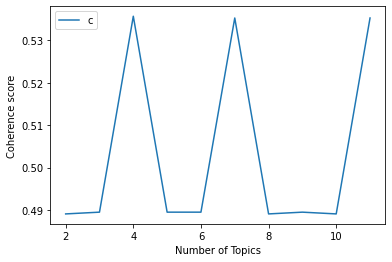

In [ ]:
start,stop,step=2,12,1
plot_graph(preprocess_data(data),start,stop,step)

In [ ]:
# Write your code here
model=create_gensim_lsa_model(preprocess_data(data),number_of_topics,words)

[(0, '0.580*"languag" + 0.572*"process" + 0.565*"natur" + 0.067*"learn" + 0.040*"retriev" + 0.035*"inform" + 0.029*"use" + 0.028*"system" + 0.023*"overview" + 0.022*"statist"'), (1, '-0.625*"learn" + 0.417*"retriev" + 0.385*"inform" + 0.213*"use" + -0.148*"comput" + -0.127*"assist" + -0.126*"deep" + -0.109*"speech" + -0.109*"base" + -0.105*"part"'), (2, '0.523*"retriev" + 0.490*"inform" + 0.455*"learn" + 0.223*"use" + 0.101*"case" + 0.101*"part" + 0.101*"driven" + 0.101*"studi" + 0.101*"error" + 0.101*"transform"'), (3, '0.320*"base" + 0.306*"speech" + 0.264*"studi" + 0.264*"transform" + 0.264*"tag" + 0.264*"error" + 0.264*"driven" + 0.264*"case" + 0.264*"part" + -0.231*"network"'), (4, '0.717*"system" + 0.360*"evalu" + 0.241*"overview" + 0.180*"relat" + 0.180*"lolita" + 0.146*"histor" + 0.142*"toward" + 0.142*"adapt" + 0.142*"context" + -0.133*"network"'), (5, '-0.449*"network" + -0.364*"neural" + 0.291*"assist" + -0.272*"deep" + -0.265*"architectur" + -0.265*"multitask" + -0.265*"uni

## (3) (10 points) Generate K topics by using  lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

In [ ]:
# Write your code here





## (4) (10 points) Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [ ]:
# Write your code here

%%capture
!pip install bertopic



In [ ]:
from sklearn.datasets import fetch_20newsgroups
docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']
print(data)

[' Foundations of statistical natural language processing ', ' A Maximum Entropy approach to Natural Language Processing ', ' Natural Language Processing ', ' Linguistics and Natural Language Processing ', ' Natural Language Processing ', ' Natural language processing (almost) from scratch ', ' Natural language processing ', ' Natural Language Processing/Robotics ', ' Tutorial on Natural Language Processing ', ' Ambiguities in Natural Language Processing ', ' Statistical Natural Language Processing ', ' Natural Language Processing for Information Retrieval ', ' Natural Language Processing ', ' Natural language processing of lyrics ', ' Transformation-Based Error-Driven Learning and Natural Language Processing: A Case Study in Part-of-Speech Tagging ', ' Connectionist Natural Language Processing ', ' Chaos and Natural Language Processing ', ' Natural Language Processing: ', ' Natural language processing: an introduction ', ' Overview of Natural Language Processing ', ' Natural Language 

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)

/usr/local/lib/python3.7/dist-packages/numba/core/types/__init__.py:108: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  long_ = _make_signed(np.long)
/usr/local/lib/python3.7/dist-packages/numba/core/types/__init__.py:109: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need t

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/589 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprec

In [ ]:
freq = topic_model.get_topic_info(); freq.head(5)


,Topic,Count,Name
0,-1,6534,-1_to_the_of_and
1,0,1837,0_game_team_games_he
2,1,605,1_key_clipper_chip_encryption
3,2,524,2_ites_cheek_yep_huh
4,3,385,3_car_engine_cars_ford


In [ ]:
topic_model.get_topic(0)  # Select the most frequent topic

[('game', 0.010363882434877361),
 ('team', 0.00902288437557313),
 ('games', 0.0071894903863804665),
 ('he', 0.007009328554892173),
 ('players', 0.006320002780263111),
 ('season', 0.006238651802441724),
 ('hockey', 0.0061274934333757376),
 ('play', 0.005782606360359752),
 ('25', 0.005644932732035171),
 ('year', 0.005597692031261657)]

In [ ]:
topic_model.visualize_topics()

/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
/usr/local/lib/python3.7/dist-packages/numba/core/ir_util

In [ ]:
topic_model.visualize_distribution(probs[200], min_probability=0.015)

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

/usr/local/lib/python3.7/dist-packages/plotly/figure_factory/_dendrogram.py:350: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/usr/local/lib/python3.7/dist-packages/plotly/figure_factory/_dendrogram.py:351: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/usr/local/lib/python3.7/dist-packages/plotly/figure_factory/_dendrogram.py:352: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/usr/local/lib/python3.7/dist-packages/plotly/figure_factory/_dendrogram.py:353: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead



In [ ]:
topic_model.visualize_barchart(top_n_topics=5)

## (5) (10 extra points) Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
# Write your answer here (no code needed for this question)

'''Topic Modelling can be evaluated by the concept of Topic Coherence.There are many techniques that are used to obtain topic models.They are: 
 Latent Semantic Analysis(LSA) and Latent Dirichlet Allocation (LDA) .
LDA:
The two main inputs to the LDA topic model are the dictionary and the corpus. Gensim creates a unique id for each word in the document.In addition to the corpus and dictionary, we need to provide the number of topics as well.
We can use LDA visualization tool pyLDAvis, by trying a few numbers of topics and comparing the results.Topic coherence is one of the main techniques used to estimate the number of topics.
We need to build many LDA models with different values of the number of topics (k) and pick the one that gives the highest coherence value. Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics.
The  plot of coherence value and number of topics shows that coherence score decreases with the number of topics.Optimum topics score is observed at 10.
and also coherence value observed for the data using LDA algorithm is 0.62

LSA:
LSA is typically used as a dimension reduction or noise reducing technique.
The best way to determine k (number of topics) in topic modeling, is by using Topic coherence measure which is a realistic measure for identifying the number of topics.The high value of topic coherence score model will be considered as a good topic model.
For the Plot i.e.,coherence value and number of topics using LSA algorithm the Optimum coherence score is observed at 0,54 with topic at 6.

So from the analysis, LDA gives better results than LSA .

